In [22]:
import sqc
import numpy as np
from exercises import CRz,qft,C2NOT
import matplotlib.pyplot as plt

In [62]:
# Only implement improved trotter
def CT(c,xbits,Ntrot,dt,op,params):
    op=CT0(c,xbits,dt/Ntrot/2.,op,params)
    for i in range(Ntrot-1):
        op=CT1(c,xbits,dt/Ntrot,op,params)
        op=CT0(c,xbits,dt/Ntrot,op,params)
    op=CT1(c,xbits,dt/Ntrot,op,params)
    op=CT0(c,xbits,dt/Ntrot/2.,op,params)
    return op

# Helper
def period(x,L):
    if x >= L/2:
        return x - L
    return x

def w(j,N):
    assert(j<N and j>=0)
    if j == N-1:
        return -2**j
    return 2**j

# exp(I a x)
def CexpIaX(c,a,xbits,op):
    N=len(xbits)
    for j in range(len(xbits)):
        op=CRz(c,xbits[j],a*w(j,N),op)
    return op

# exp(I a p)
def CexpIaP(c,a,xbits,op):
    N=len(xbits)
    op=qft(op,mask=xbits,inverse=False)
    op=CexpIaX(c,a*2.*np.pi / 2**N,xbits,op)
    op=qft(op,mask=xbits,inverse=True)
    return op

# exp(I a x^2)
def CexpIaX2(c,a,xbits,op):
    N=len(xbits)
    l=a/12.*(2.+4.**N)-a/2.
    op=CRz(c,xbits[0],l,CRz(c,xbits[0],l,op.X(xbits[0])).X(xbits[0]))
    for j in range(len(xbits)):
        op=CRz(c,xbits[j],-a*w(j,N),op)
        for i in range(len(xbits)):
            if i != j:
                t=a/4.*w(j,N)*w(i,N)
                ga=xbits[i]
                gb=xbits[j]
                op=op.CNOT(gb,ga)
                op=op.X(ga)
                op=CRz(c,ga,t,op)
                op=op.X(ga)
                op=CRz(c,ga,-t,op)
                op=op.CNOT(gb,ga)
    return op

# exp(I a p^2)
def CexpIaP2(c,a,xbits,op):
    N=len(xbits)
    op=qft(op,mask=xbits,inverse=False)
    op=CexpIaX2(c,a*(2.*np.pi / 2**N)**2.,xbits,op)
    op=qft(op,mask=xbits,inverse=True)
    return op

# Simple potential
def C2Rz(c0,c1,t,phi,o):
    o=CRz(c0,t,phi/2.,o)
    o=C2NOT(c0,c1,t,o)
    o=CRz(c0,t,-phi/2.,o)
    o=CRz(c0,c1,phi/2.,o)
    o=C2NOT(c0,c1,t,o)
    return o

In [80]:
# Kinetic term
def CT0(c,xbits,dt,op,params):
    mass=params[0]
    return CexpIaP2(c,dt/2.0/mass,xbits,op)

# Potential term
def CT1(c,xbits,dt,op,params):
    V0=params[1]
    c0=xbits[-1]
    c1=xbits[-2]
    return C2Rz(c,c0,c1,V0*dt,op.X(c0)).X(c0)

In [81]:
nabits=1
nxbits=5
nbits=nabits+nxbits
s0=sqc.state(nbits,basis=["|%d>|%d>" % (x//2**nxbits,period(x%2**nxbits,2**nxbits))
                          for x in range(2**nbits)])
s1=CT1(nxbits,range(nxbits),1.,sqc.operator(nbits).H(0).H(1).H(2).H(3).H(4).X(nxbits),[1,1])*s0
print(s1)

   0.176777              * |1>|0>
 + 0.176777              * |1>|1>
 + 0.176777              * |1>|2>
 + 0.176777              * |1>|3>
 + 0.176777              * |1>|4>
 + 0.176777              * |1>|5>
 + 0.176777              * |1>|6>
 + 0.176777              * |1>|7>
 + (0.0955129+0.148752j) * |1>|8>
 + (0.0955129+0.148752j) * |1>|9>
 + (0.0955129+0.148752j) * |1>|10>
 + (0.0955129+0.148752j) * |1>|11>
 + (0.0955129+0.148752j) * |1>|12>
 + (0.0955129+0.148752j) * |1>|13>
 + (0.0955129+0.148752j) * |1>|14>
 + (0.0955129+0.148752j) * |1>|15>
 + 0.176777              * |1>|-16>
 + 0.176777              * |1>|-15>
 + 0.176777              * |1>|-14>
 + 0.176777              * |1>|-13>
 + 0.176777              * |1>|-12>
 + 0.176777              * |1>|-11>
 + 0.176777              * |1>|-10>
 + 0.176777              * |1>|-9>
 + 0.176777              * |1>|-8>
 + 0.176777              * |1>|-7>
 + 0.176777              * |1>|-6>
 + 0.176777              * |1>|-5>
 + 0.176777            

In [82]:
def timeEvolutionPlot(dt,steps,s1,Ntrot,params):
    Tdt=CT(nxbits,range(nxbits),Ntrot,dt,sqc.operator(nbits),params)
    print(len(Tdt.m))
    sn=s1
    for tstep in range(steps):
        res=sqc.sample(sn, n=100, mask=range(nxbits))
        sn=Tdt*sn
    
        xvals=[ period(x,2**nxbits) for x in res.keys() ]
        yvals=res.values()

        plt.xlabel('x')
        plt.xlim(-2**nxbits/2,2**nxbits/2)
        plt.ylabel('count')
        plt.title('t=%g' % (tstep*dt))
        plt.bar(xvals,yvals,width=0.75)
        plt.show()
        
def createSource(xbits,p,op):
    n=len(xbits)
    for i in range(n):
        op=op.H(xbits[i]).Rz(xbits[i],-p*2**i)
    return op


nabits=1
nxbits=8
nbits=nabits+nxbits
s0=sqc.state(nbits,basis=["|%d>|%d>" % (x//2**nxbits,period(x%2**nxbits,2**nxbits))
                          for x in range(2**nbits)])

s1=createSource(range(4),2*np.pi/2**nxbits*64,sqc.operator(nbits).X(nxbits))*s0
print(s1)

   0.25    * |1>|0>
 + -0.25j  * |1>|1>
 + (-0.25) * |1>|2>
 + 0.25j   * |1>|3>
 + 0.25    * |1>|4>
 + -0.25j  * |1>|5>
 + (-0.25) * |1>|6>
 + 0.25j   * |1>|7>
 + 0.25    * |1>|8>
 + -0.25j  * |1>|9>
 + (-0.25) * |1>|10>
 + 0.25j   * |1>|11>
 + 0.25    * |1>|12>
 + -0.25j  * |1>|13>
 + (-0.25) * |1>|14>
 + 0.25j   * |1>|15>


14066


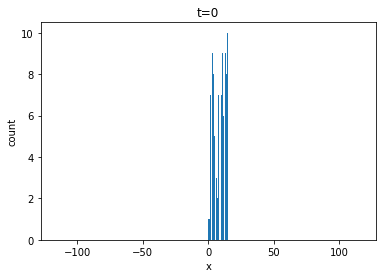

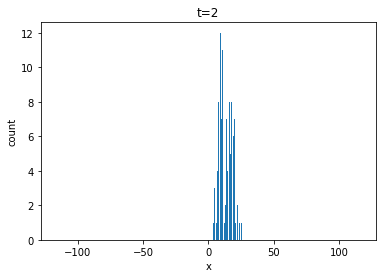

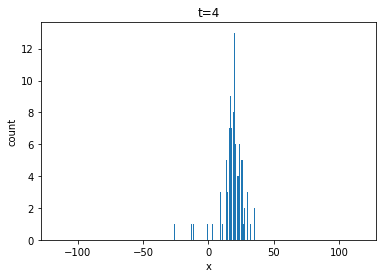

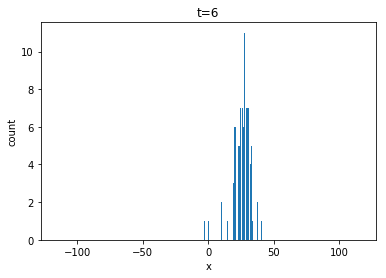

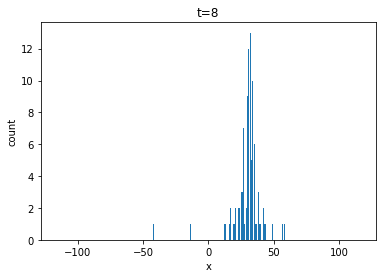

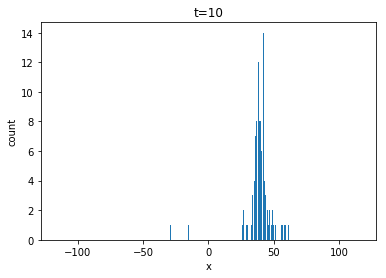

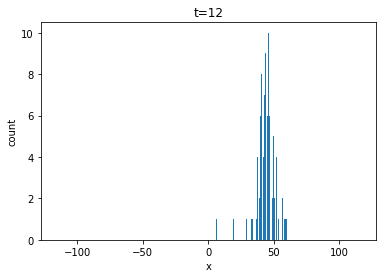

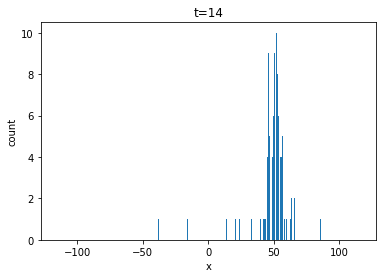

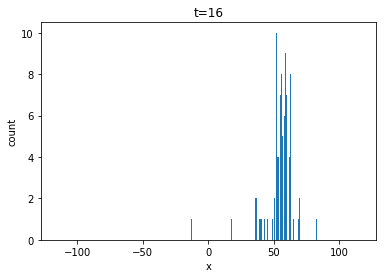

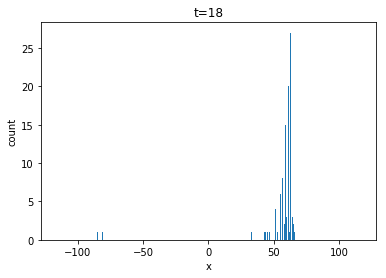

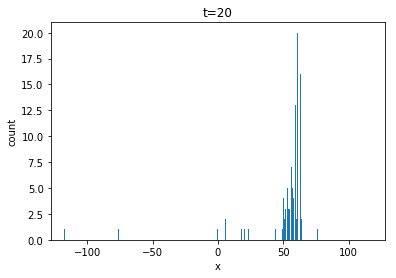

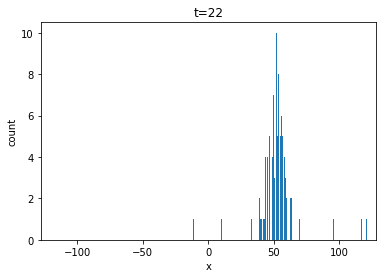

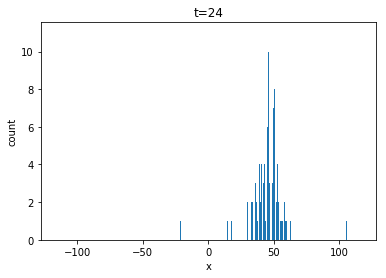

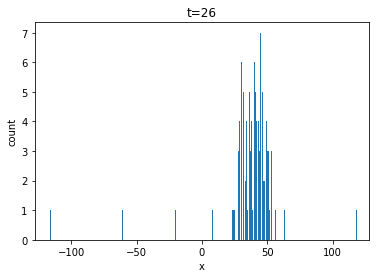

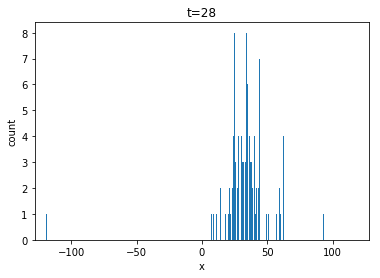

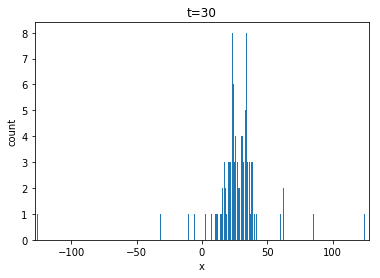

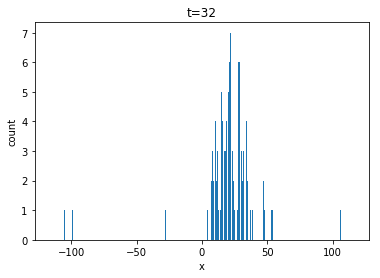

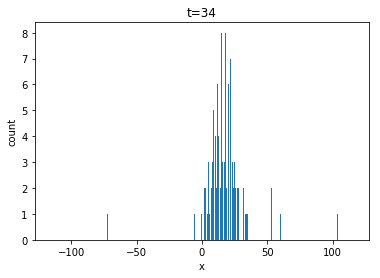

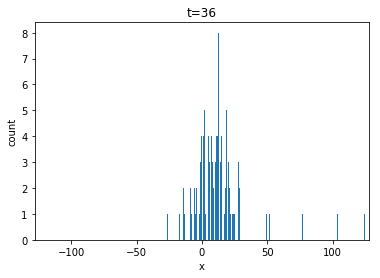

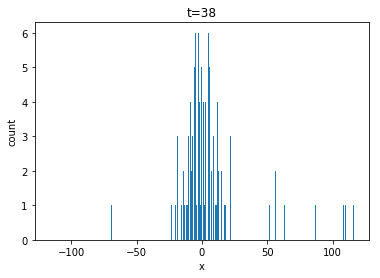

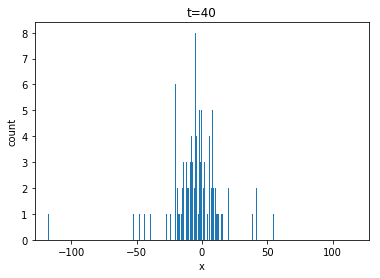

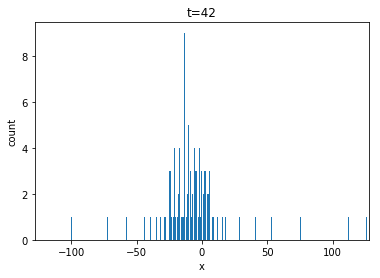

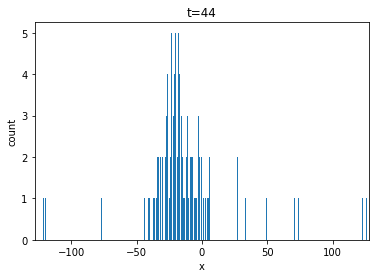

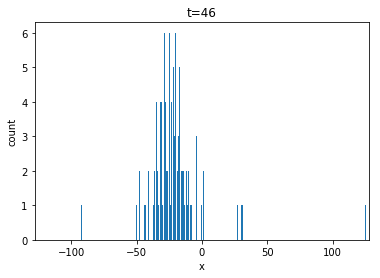

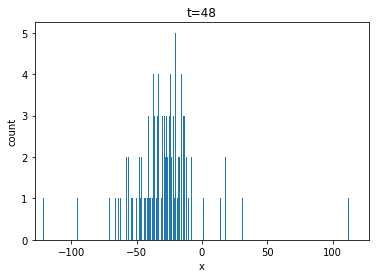

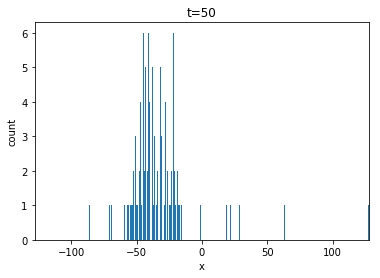

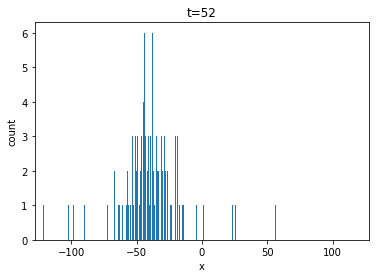

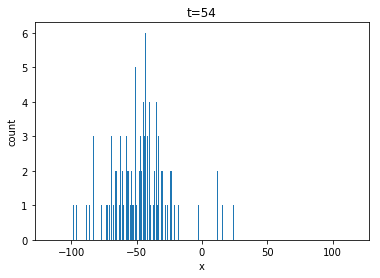

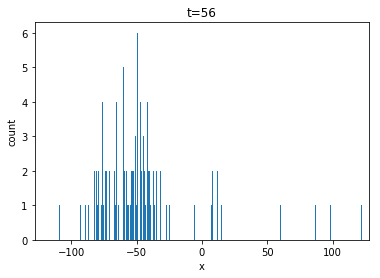

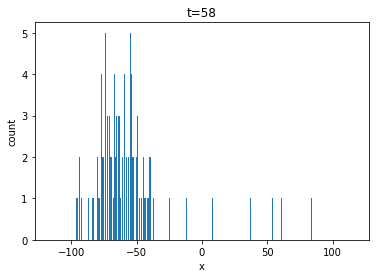

In [84]:
timeEvolutionPlot(2,30,s1,10,[0.5,3.5]) # Hard wall

14066


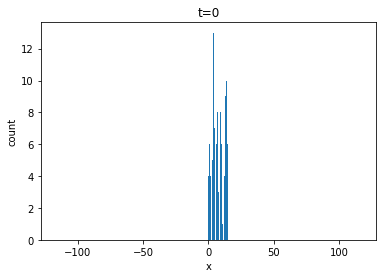

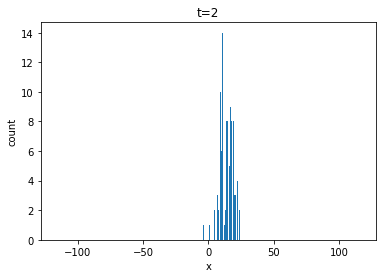

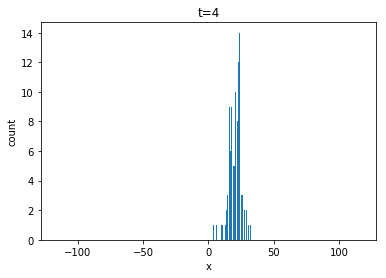

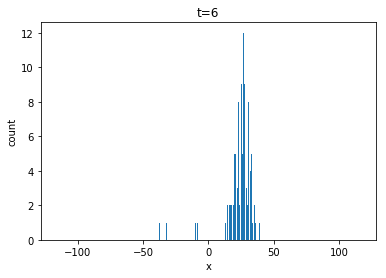

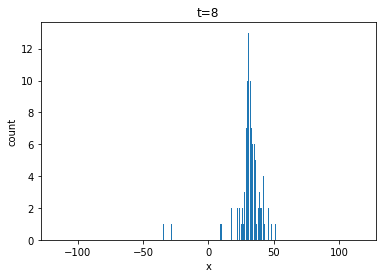

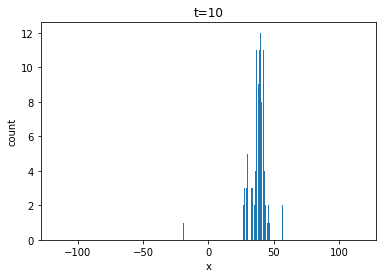

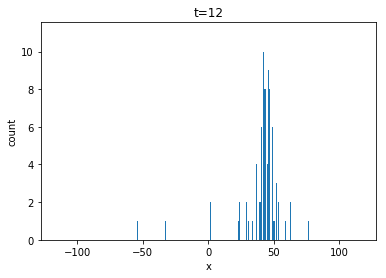

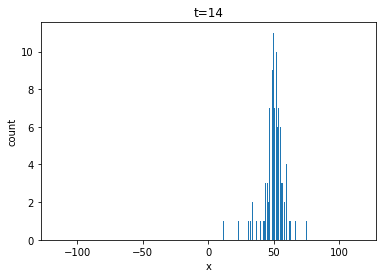

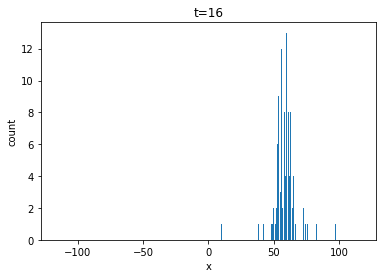

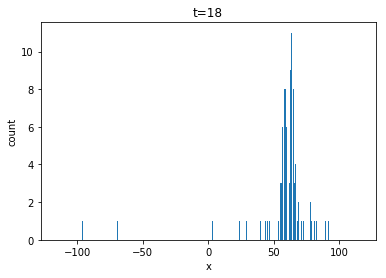

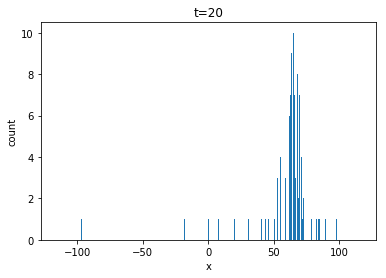

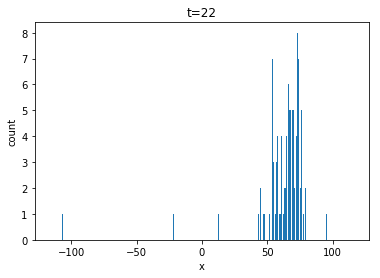

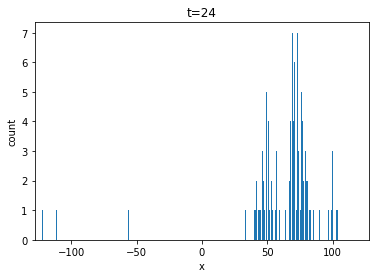

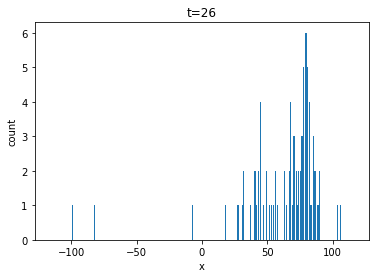

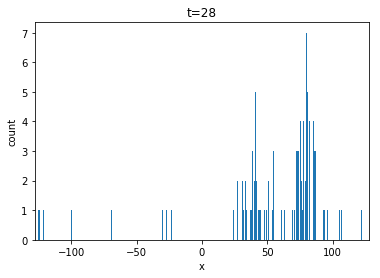

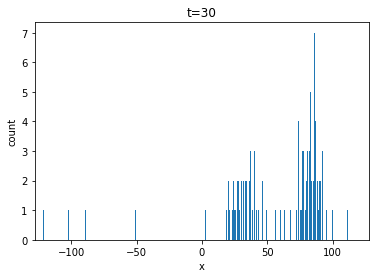

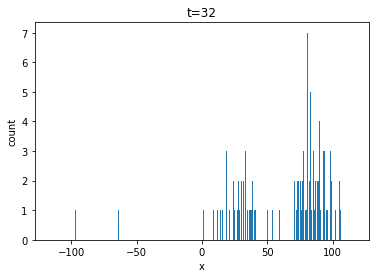

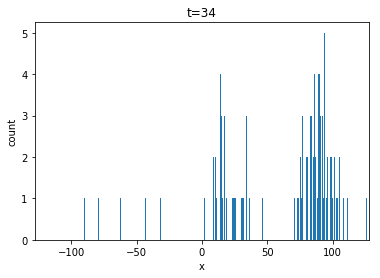

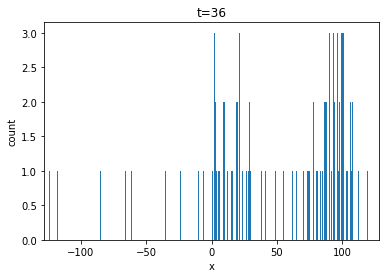

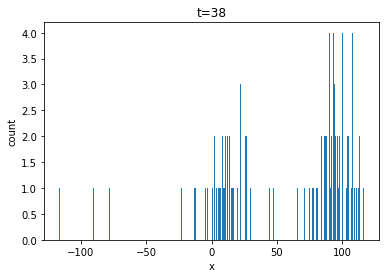

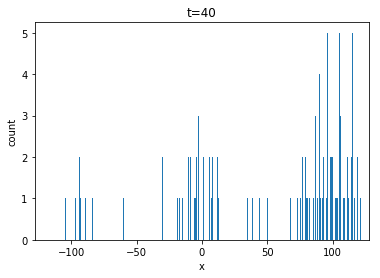

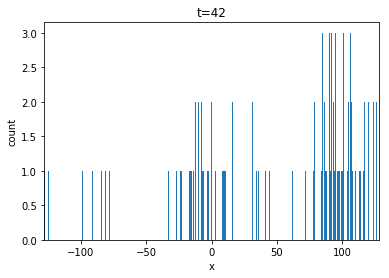

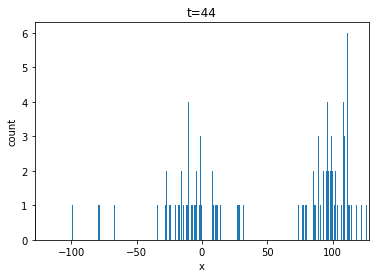

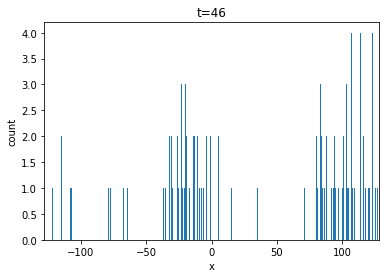

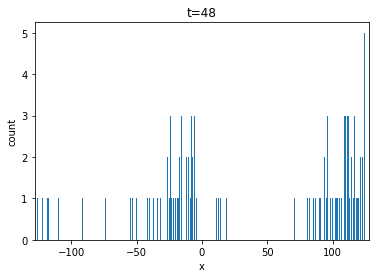

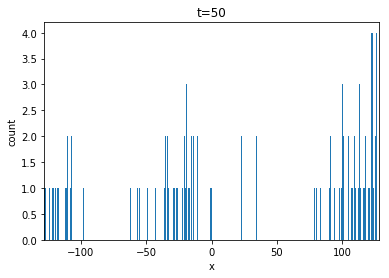

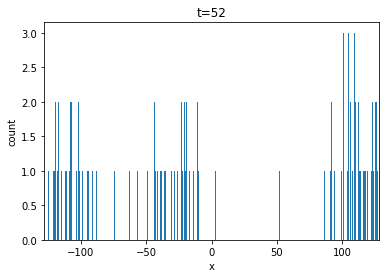

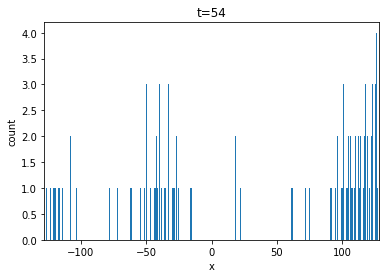

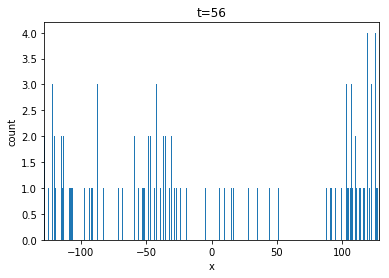

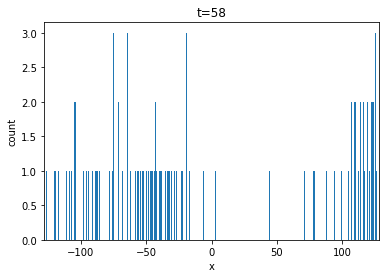

In [86]:
timeEvolutionPlot(2,30,s1,10,[0.5,2.0])

20521


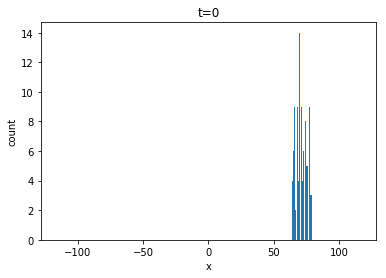

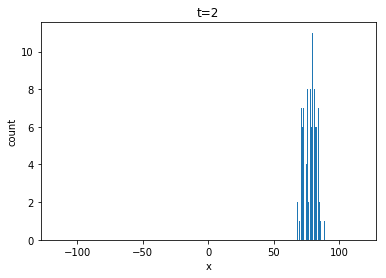

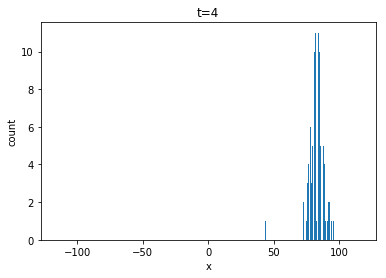

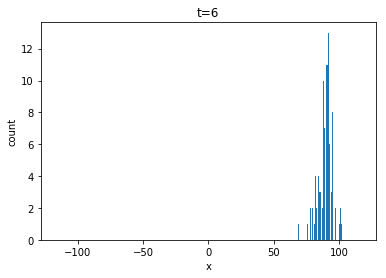

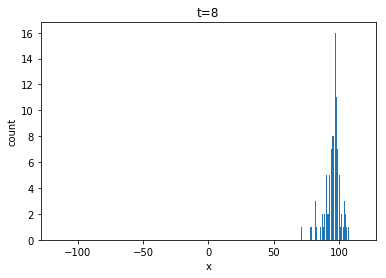

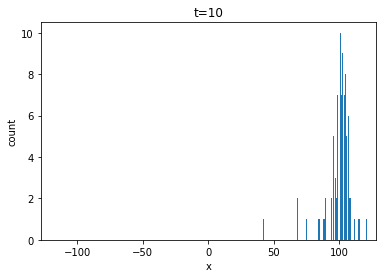

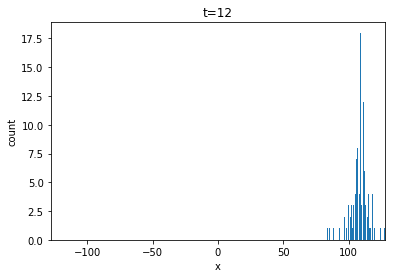

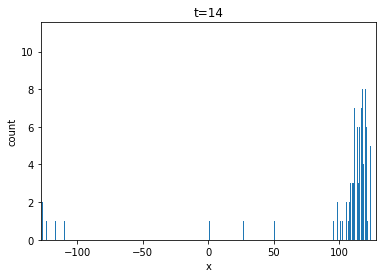

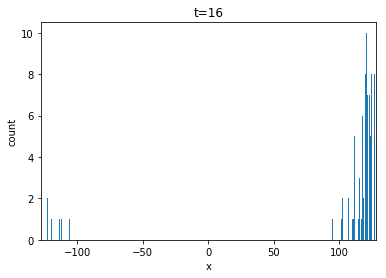

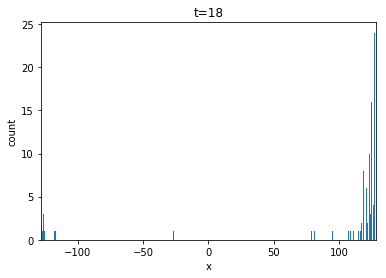

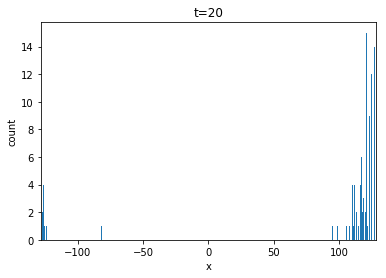

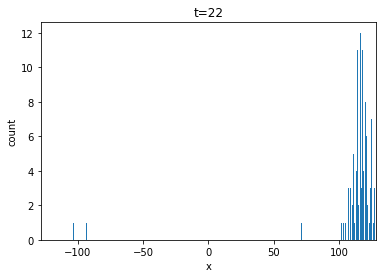

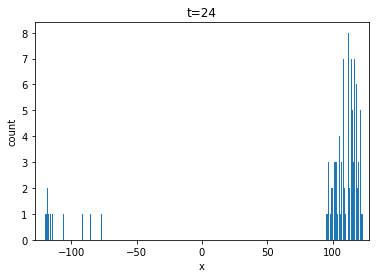

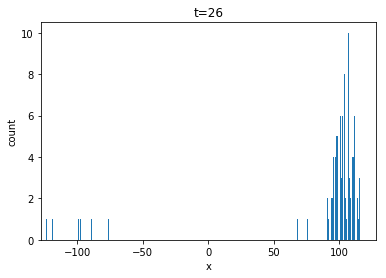

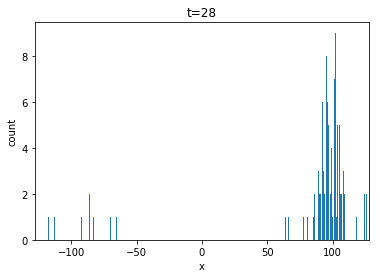

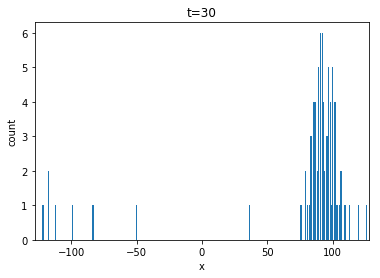

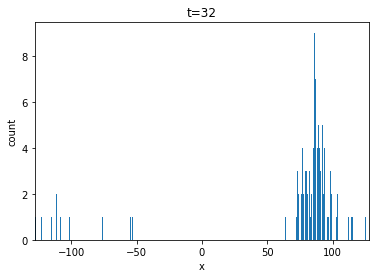

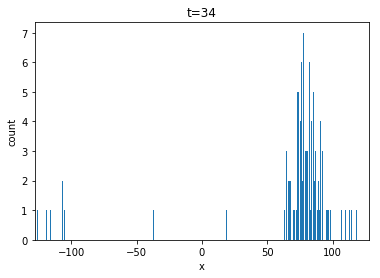

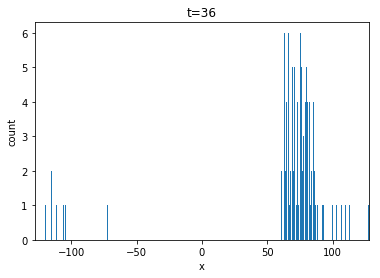

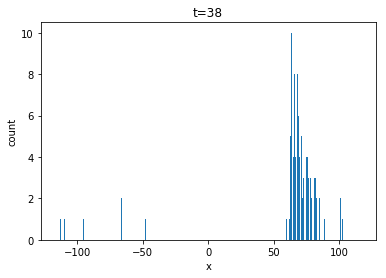

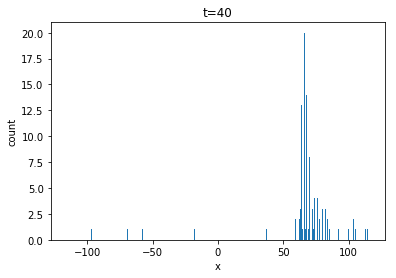

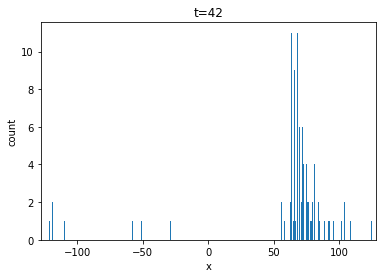

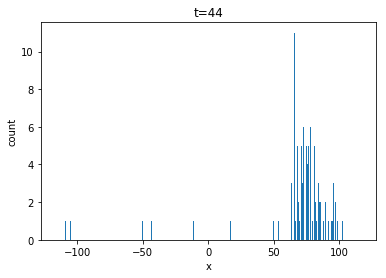

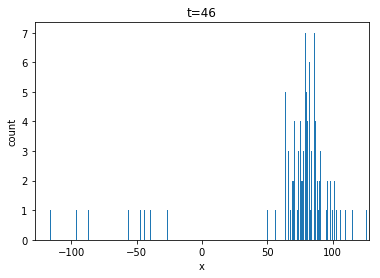

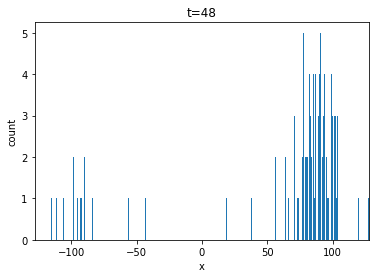

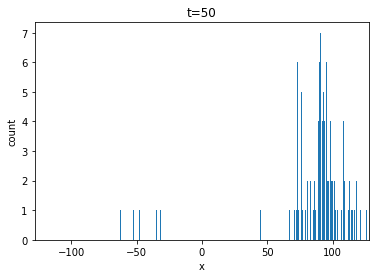

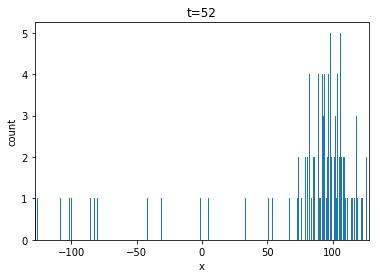

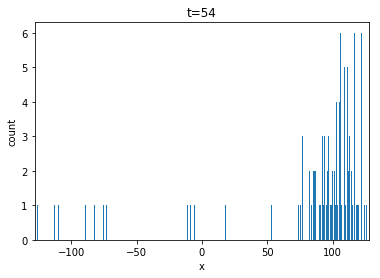

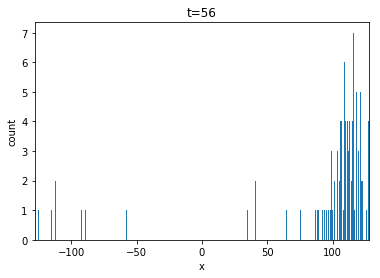

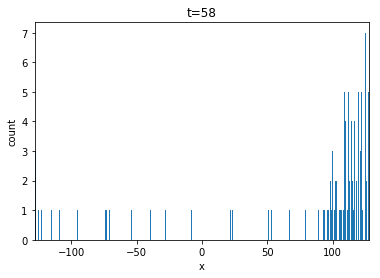

In [90]:
timeEvolutionPlot(2,30,sqc.operator(nbits).X(6)*s1,15,[0.5,-3.0])